In [ ]:
! pip install -q onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
! pip install -q onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 46.4 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import sys
import os

# Set paths
EMB_PATH = "/content/public_embeddings_seed61437433_port9732.npz"
IMG_PATH = "/content/ModelStealingPub.pt"

print("Loading from:")
print(" - Embeddings:", EMB_PATH)
print(" - Images:", IMG_PATH)


Loading from:
 - Embeddings: /content/public_embeddings_seed61437433_port9732.npz
 - Images: /content/ModelStealingPub.pt


## training base encoder on victim embeddings i.e. stolen encoder

In [ ]:
# --- Begin: Dataset class definitions needed for torch.load ---
import torch
from torch.utils.data import Dataset
from typing import Tuple

class TaskDataset(Dataset):
    def __init__(self, transform=None):
        self.ids = []
        self.imgs = []
        self.labels = []
        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)
# --- End: Dataset class definitions ---


In [ ]:
# Load the victim .npz
data = np.load(EMB_PATH)
indices = data["indices"]
reps = data["reps"]
seed = int(data["seed"])
port = int(data["port"])

print("Loaded embeddings:", reps.shape)

# Load the corresponding public image dataset (.pt)
dataset = torch.load(IMG_PATH, weights_only=False)
images  = [dataset.imgs[i] for i in indices]

# Ensure length matches
assert len(images) == reps.shape[0]
print("Loaded matching images:", len(images))


Loaded embeddings: (1000, 1024)
Loaded matching images: 1000


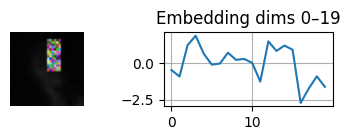

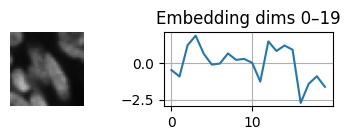

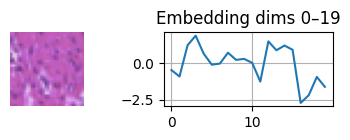

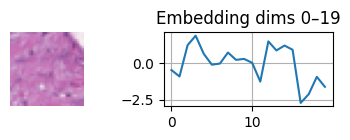

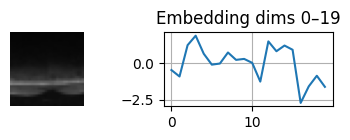

In [ ]:
# Show first 5 images and their first 20 embedding dims
for i in range(5):
    img = images[i]
    emb = reps[i]

    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(emb[:20])
    plt.title("Embedding dims 0–19")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Define Stolen Encoder Architecture

import torch
import torch.nn as nn
from torchvision.models import resnet18

class StolenEncoder(nn.Module):
    def __init__(self, pretrained_backbone=False):
        super().__init__()
        # 1) Backbone
        self.backbone = resnet18(pretrained=pretrained_backbone)
        # Remove the original classification head
        self.backbone.fc = nn.Identity()
        # 2) Projection head to get 1024-dim outputs
        self.proj = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def forward(self, x):
        # x shape: (B,3,32,32)
        feat = self.backbone(x)     # (B,512)
        rep  = self.proj(feat)      # (B,1024)
        return rep

# Quickly test shape
model = StolenEncoder(pretrained_backbone=False)
x = torch.randn(4, 3, 32, 32)
y = model(x)
print("➡️ StolenEncoder output shape:", y.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


➡️ StolenEncoder output shape: torch.Size([4, 1024])


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Basic transforms to convert PIL → Tensor + normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class StealingDataset(Dataset):
    def __init__(self, images, embeddings, transform=None):
        """
        images: list of PIL.Image
        embeddings: numpy array (N,1024)
        """
        self.images     = images
        self.embeddings = torch.from_numpy(embeddings).float()
        self.transform  = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      img = self.images[idx]
      if img.mode != 'RGB':
          img = img.convert("RGB")
      if self.transform:
          img = self.transform(img)
      rep = self.embeddings[idx]
      return img, rep


# Instantiate dataset & dataloader
dataset_ssl = StealingDataset(images, reps, transform=transform)
loader_ssl  = DataLoader(dataset_ssl, batch_size=64, shuffle=True, num_workers=2)

print("Dataset size:", len(dataset_ssl))
# print("One batch shapes:", next(iter(loader_ssl))[0].shape, next(iter(loader_ssl))[1].shape)


Dataset size: 1000


In [ ]:
# Set up training components

import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = StolenEncoder(pretrained_backbone=False).to(device)

# Loss: MSE between student & victim embeddings
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# (Optional) learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Using device: cuda


In [ ]:
# Train for one epoch & log loss

model.train()
running_loss = 0.0

for batch_idx, (imgs, target_reps) in enumerate(loader_ssl, 1):
    imgs = imgs.to(device)                  # (B,3,32,32)
    target_reps = target_reps.to(device)    # (B,1024)

    optimizer.zero_grad()
    pred_reps = model(imgs)                 # (B,1024)
    loss = criterion(pred_reps, target_reps)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if batch_idx % 50 == 0:
        print(f"  [Batch {batch_idx}] Avg Loss: {running_loss / batch_idx:.4f}")

# Step the scheduler
scheduler.step()

epoch_loss = running_loss / len(loader_ssl)
print(f"→ Epoch Loss: {epoch_loss:.4f}")


→ Epoch Loss: 0.6501


[Epoch 1/50] Loss: 0.2345
[Epoch 2/50] Loss: 0.0568
[Epoch 3/50] Loss: 0.0221
[Epoch 4/50] Loss: 0.0126
[Epoch 5/50] Loss: 0.0085
[Epoch 6/50] Loss: 0.0069
[Epoch 7/50] Loss: 0.0056
[Epoch 8/50] Loss: 0.0066
[Epoch 9/50] Loss: 0.0055
[Epoch 10/50] Loss: 0.0042
[Epoch 11/50] Loss: 0.0039
[Epoch 12/50] Loss: 0.0037
[Epoch 13/50] Loss: 0.0032
[Epoch 14/50] Loss: 0.0036
[Epoch 15/50] Loss: 0.0031
[Epoch 16/50] Loss: 0.0030
[Epoch 17/50] Loss: 0.0027
[Epoch 18/50] Loss: 0.0029
[Epoch 19/50] Loss: 0.0027
[Epoch 20/50] Loss: 0.0026
[Epoch 21/50] Loss: 0.0026
[Epoch 22/50] Loss: 0.0024
[Epoch 23/50] Loss: 0.0029
[Epoch 24/50] Loss: 0.0028
[Epoch 25/50] Loss: 0.0031
[Epoch 26/50] Loss: 0.0026
[Epoch 27/50] Loss: 0.0025
[Epoch 28/50] Loss: 0.0028
[Epoch 29/50] Loss: 0.0025
[Epoch 30/50] Loss: 0.0024
[Epoch 31/50] Loss: 0.0023
[Epoch 32/50] Loss: 0.0022
[Epoch 33/50] Loss: 0.0022
[Epoch 34/50] Loss: 0.0026
[Epoch 35/50] Loss: 0.0021
[Epoch 36/50] Loss: 0.0023
[Epoch 37/50] Loss: 0.0024
[Epoch 38/

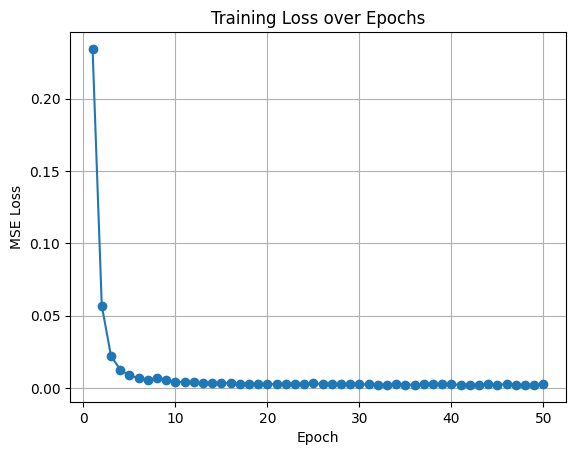

In [ ]:
# Cell: Run multiple epochs and plot loss curve

num_epochs = 50
history = []

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0

    for imgs, target_reps in loader_ssl:
        imgs = imgs.to(device)
        target_reps = target_reps.to(device)

        optimizer.zero_grad()
        loss = criterion(model(imgs), target_reps)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()
    avg = total_loss / len(loader_ssl)
    history.append(avg)
    print(f"[Epoch {epoch}/{num_epochs}] Loss: {avg:.4f}")

# Plot loss curve
plt.figure()
plt.plot(range(1, num_epochs+1), history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


In [ ]:
# Save PyTorch model
torch.save(model.state_dict(), "/content/models/stolen_encoder.pth")
print("Saved PyTorch model")


Saved PyTorch model


In [ ]:
! pip install -q onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 116.9 MB/s eta 0:00:00


In [ ]:
import os
import torch.onnx
import onnxruntime

# Path to save
onnx_path = "/content/models/stolen_encoder.onnx"

# Dummy input for tracing (match (1,3,32,32))
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Export the model
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["x"],
    output_names=["embedding"],
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    verbose=False
)

print(f"Exported ONNX model to: {onnx_path}")


Exported ONNX model to: /content/models/stolen_encoder.onnx


## SIMCLR

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Path to victim embeddings and image dataset
EMB_PATH = "/content/public_embeddings_seed61437433_port9732.npz"
IMG_PATH = "/content/ModelStealingPub.pt"


In [ ]:
# Load victim embeddings and image indices
data = np.load(EMB_PATH)
reps = data["reps"]       # shape: (N,1024)
indices = data["indices"]

In [ ]:
# Load full dataset and extract relevant images
full_dataset = torch.load(IMG_PATH, weights_only=False)
images = [full_dataset.imgs[i] for i in indices]

print(f"Loaded {len(images)} images and {reps.shape[0]} victim embeddings")

Loaded 1000 images and 1000 victim embeddings


In [ ]:
# SimCLR augmentations (strong)
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset class returning two views + victim rep
class SimCLRDataset(Dataset):
    def __init__(self, images, victim_reps, transform):
        self.images = images
        self.vreps = torch.from_numpy(victim_reps).float()
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if img.mode != 'RGB':
            img = img.convert("RGB")
        t1 = self.transform(img)
        t2 = self.transform(img)
        rep = self.vreps[idx]
        return t1, t2, rep

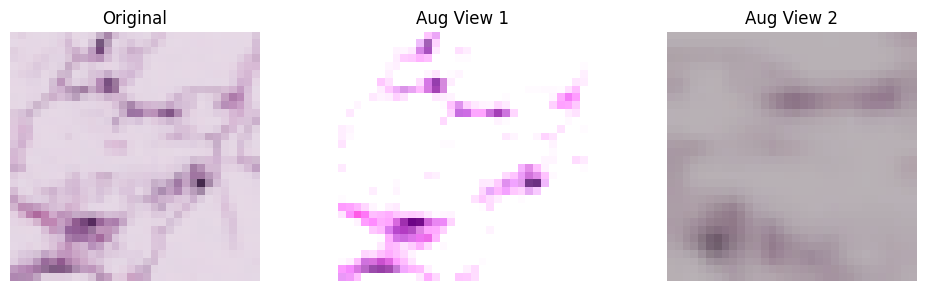

In [ ]:
# Show original image and two augmented views
img_example = images[9]
aug1 = simclr_transform(img_example)
aug2 = simclr_transform(img_example)

# Convert tensors back to image format for display
def deprocess(t):
    t = t.clone().detach().permute(1,2,0)
    t = t * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    return t.clamp(0, 1).numpy()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(img_example)
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(deprocess(aug1))
plt.title("Aug View 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(deprocess(aug2))
plt.title("Aug View 2")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision import models

class StolenEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x


# class StolenEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = models.resnet50(pretrained=False)
#         self.backbone.fc = nn.Identity()
#         self.head = nn.Sequential(
#             nn.Linear(2048, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024)
#         )

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.head(x)
#         return x

### MSE losses

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Loss: 1.7684
[Epoch 2] Loss: 1.7162
[Epoch 3] Loss: 1.6546
[Epoch 4] Loss: 1.6054
[Epoch 5] Loss: 1.5868
[Epoch 6] Loss: 1.5761
[Epoch 7] Loss: 1.5660
[Epoch 8] Loss: 1.5575
[Epoch 9] Loss: 1.5524
[Epoch 10] Loss: 1.5421
[Epoch 11] Loss: 1.5416
[Epoch 12] Loss: 1.5347
[Epoch 13] Loss: 1.5324
[Epoch 14] Loss: 1.5248
[Epoch 15] Loss: 1.5190


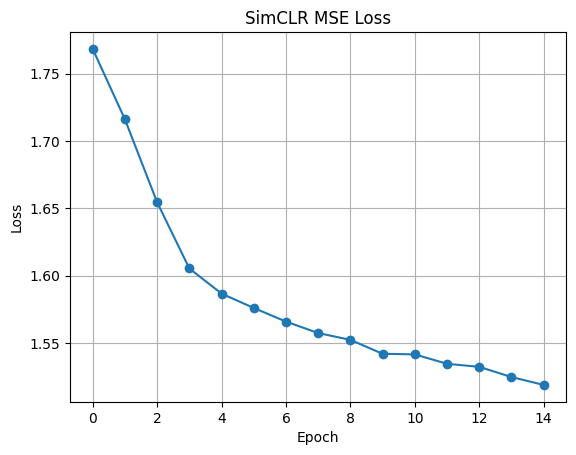

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StolenEncoder().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)

# alpha = 0.9  # weight between victim alignment and self-consistency
# num_epochs = 15
# loss_history = []

# for epoch in range(1, num_epochs+1):
#     model.train()
#     total = 0
#     for t1, t2, yv in loader:
#         t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

#         optimizer.zero_grad()
#         o1 = model(t1)         # (B,1024)
#         o2 = model(t2)         # (B,1024)
#         loss_A = F.mse_loss(o1, yv)
#         loss_B = F.mse_loss(o2, o1.detach())
#         loss = alpha * loss_A + (1 - alpha) * loss_B              # contrastive/old loss/MSE aggregated loss
#         # loss = 1 - F.cosine_similarity(o1, yv, dim=1).mean()        # cosine similarity loss
#         loss.backward()
#         optimizer.step()
#         total += loss.item()

#     avg = total / len(loader)
#     loss_history.append(avg)
#     print(f"[Epoch {epoch}] Loss: {avg:.4f}")

# # Plot training loss
# plt.plot(loss_history, marker='o')
# plt.title("SimCLR MSE Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()


[Epoch 1] Loss: 0.6319
[Epoch 2] Loss: 0.2394
[Epoch 3] Loss: 0.0578
[Epoch 4] Loss: 0.0189
[Epoch 5] Loss: 0.0107
[Epoch 6] Loss: 0.0074
[Epoch 7] Loss: 0.0067
[Epoch 8] Loss: 0.0052
[Epoch 9] Loss: 0.0054
[Epoch 10] Loss: 0.0051
[Epoch 11] Loss: 0.0042
[Epoch 12] Loss: 0.0046
[Epoch 13] Loss: 0.0038
[Epoch 14] Loss: 0.0038
[Epoch 15] Loss: 0.0035
[Epoch 16] Loss: 0.0036
[Epoch 17] Loss: 0.0031
[Epoch 18] Loss: 0.0029
[Epoch 19] Loss: 0.0034
[Epoch 20] Loss: 0.0029
[Epoch 21] Loss: 0.0030
[Epoch 22] Loss: 0.0029
[Epoch 23] Loss: 0.0027
[Epoch 24] Loss: 0.0028
[Epoch 25] Loss: 0.0026
[Epoch 26] Loss: 0.0027
[Epoch 27] Loss: 0.0027
[Epoch 28] Loss: 0.0029
[Epoch 29] Loss: 0.0030
[Epoch 30] Loss: 0.0027
[Epoch 31] Loss: 0.0026
[Epoch 32] Loss: 0.0025
[Epoch 33] Loss: 0.0025
[Epoch 34] Loss: 0.0027
[Epoch 35] Loss: 0.0027
[Epoch 36] Loss: 0.0026
[Epoch 37] Loss: 0.0024
[Epoch 38] Loss: 0.0026
[Epoch 39] Loss: 0.0026
[Epoch 40] Loss: 0.0025
[Epoch 41] Loss: 0.0024
[Epoch 42] Loss: 0.0024
[

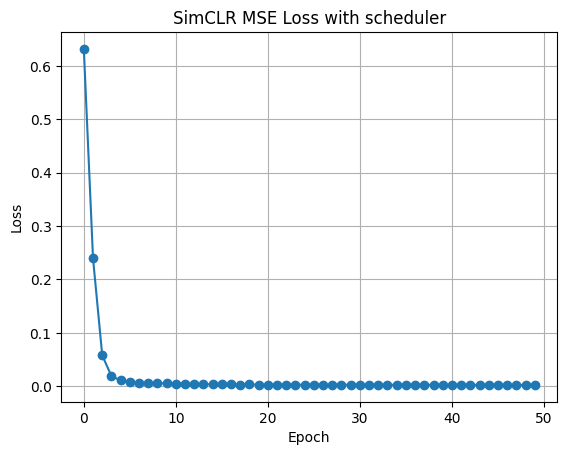

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = StolenEncoder().to(device)
# num_epochs = 50
# alpha = 0.95

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)

# loss_history = []


# for epoch in range(1, num_epochs+1):
#     model.train()
#     total = 0

#     for t1, t2, yv in loader:
#         t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

#         optimizer.zero_grad()
#         o1 = model(t1)
#         o2 = model(t2)

#         loss_A = F.mse_loss(o1, yv)
#         loss_B = F.mse_loss(o2, o1.detach())
#         loss = alpha * loss_A + (1 - alpha) * loss_B

#         loss.backward()
#         optimizer.step()
#         total += loss.item()

#     scheduler.step()

#     avg = total / len(loader)
#     loss_history.append(avg)
#     print(f"[Epoch {epoch}] Loss: {avg:.4f}")

# # Plot training loss
# plt.plot(loss_history, marker='o')
# plt.title("SimCLR MSE Loss with scheduler")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()

### MSE loss full optimized

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Loss: 0.472744
[Epoch 2] Loss: 0.060268
[Epoch 3] Loss: 0.014078
[Epoch 4] Loss: 0.009463
[Epoch 5] Loss: 0.006443
[Epoch 6] Loss: 0.005300
[Epoch 7] Loss: 0.004554
[Epoch 8] Loss: 0.004412
[Epoch 9] Loss: 0.004151
[Epoch 10] Loss: 0.004529
[Epoch 11] Loss: 0.003722
[Epoch 12] Loss: 0.003463
[Epoch 13] Loss: 0.003310
[Epoch 14] Loss: 0.003538
[Epoch 15] Loss: 0.002948
[Epoch 16] Loss: 0.002976
[Epoch 17] Loss: 0.002971
[Epoch 18] Loss: 0.002721
[Epoch 19] Loss: 0.003046
[Epoch 20] Loss: 0.002849
[Epoch 21] Loss: 0.002784
[Epoch 22] Loss: 0.002749
[Epoch 23] Loss: 0.002980
[Epoch 24] Loss: 0.002831
[Epoch 25] Loss: 0.002744
[Epoch 26] Loss: 0.002834
[Epoch 27] Loss: 0.002552
[Epoch 28] Loss: 0.002647
[Epoch 29] Loss: 0.002694
[Epoch 30] Loss: 0.002805
[Epoch 31] Loss: 0.002818
[Epoch 32] Loss: 0.002661
[Epoch 33] Loss: 0.002533
[Epoch 34] Loss: 0.002445
[Epoch 35] Loss: 0.002417
[Epoch 36] Loss: 0.002595
[Epoch 37] Loss: 0.002661
[Epoch 38] Loss: 0.002461
[Epoch 39] Loss: 0.00

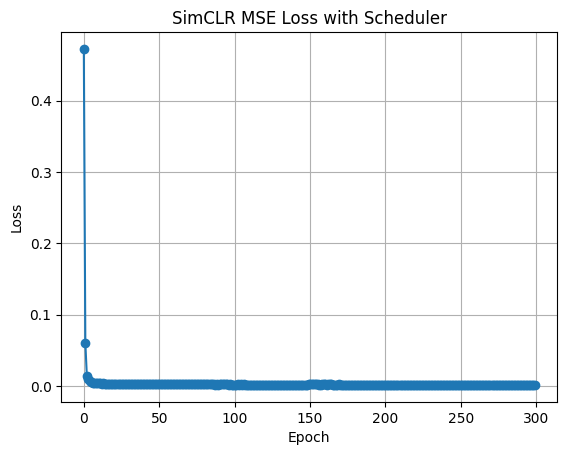

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

# === Define Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)  # Your surrogate ResNet18 + MLP head
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

# === Hyperparameters ===
alpha = 0.97                     # Try 0.97 or 0.99
num_epochs = 300
batch_size = 32
max_norm = 1.0                   # For gradient clipping

# === DataLoader ===
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform),
                    batch_size=batch_size, shuffle=True)

# === Train Loop ===
loss_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        optimizer.zero_grad()

        o1 = model(t1)               # Embedding of t1
        o2 = model(t2)               # Embedding of t2

        loss_A = F.mse_loss(o1, yv)  # Align t1 with victim's yv
        loss_B = F.mse_loss(o2, o1.detach())  # Self-consistency
        loss = alpha * loss_A + (1 - alpha) * loss_B

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)  # 🧠 Clip gradients
        optimizer.step()
        scheduler.step(epoch + total_loss)  # 🔁 Restart scheduler

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"[Epoch {epoch}] Loss: {avg_loss:.6f}")

# === Plot Training Curve ===
plt.plot(loss_history, marker='o')
plt.title("SimCLR MSE Loss with Scheduler")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## TRIAL MSE optim + procrustes

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import numpy as np, matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimCLRDataset(Dataset):
    def __init__(self, imgs, v_reps, transform):
        self.imgs = imgs
        self.vreps = torch.from_numpy(v_reps).float()
        self.tf = transform
    def __len__(self):  return len(self.imgs)
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if img.mode != "RGB": img = img.convert("RGB")
        return self.tf(img), self.tf(img), self.vreps[idx]

In [ ]:
eps = 1e-5
y_all = torch.from_numpy(reps).float()
mu = y_all.mean(0, keepdim=True)
X  = y_all - mu
cov = (X.T @ X) / (X.size(0) - 1)
U, S, _ = torch.linalg.svd(cov + eps*torch.eye(1024))
W = U @ torch.diag(1.0 / torch.sqrt(S)) @ U.T
mu, W = mu.to(device), W.to(device)

def whiten(t):                          # (B,1024) → (B,1024)
    return (t - mu) @ W

In [ ]:
class StolenEncoder(nn.Module):
    def __init__(self, add_fixer=True):
        super().__init__()
        base = resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.backbone = base
        self.head     = nn.Linear(512, 1024)
        self.add_fixer = add_fixer
        if add_fixer:
            self.fixer = nn.Linear(1024, 1024, bias=False)
            nn.init.eye_(self.fixer.weight)         # start as identity
    def encode(self, x):
        h = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.head(h)
    def forward(self, x):
        z = self.encode(x)
        return self.fixer(z) if self.add_fixer else z

In [ ]:
@torch.no_grad()
def set_procrustes(model, dl, victim_tensor):
    model.eval()
    stu_vecs = []
    for v1, _, _ in dl:
        stu_vecs.append(model.encode(v1.to(device)).cpu())
    A = torch.cat(stu_vecs, 0)                 # student (N,1024)
    B = victim_tensor                          # victim  (N,1024)
    U, _, Vt = torch.linalg.svd(B.T @ A)
    R = U @ Vt
    model.fixer.weight.data.copy_(R.to(device))


In [ ]:

# ───────────────────────────────────── 6. DataLoader ─────────────────────────────────────────
batch_size = 128
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform),
                    batch_size=batch_size, shuffle=True, drop_last=True,
                    num_workers=4, pin_memory=True)

In [ ]:
# ───────────────────────────────────── 7. Phase-1: 300-epoch steal ───────────────────────────
model = StolenEncoder(add_fixer=True).to(device)
for p in model.fixer.parameters():   p.requires_grad_(False)   # freeze fixer during Phase-1

alpha   = 0.98
opt     = torch.optim.Adam(model.parameters(), lr=1e-4)
sched   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=300)
loss_hist = []

for epoch in range(1, 301):
    model.train()
    total = 0.0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)
        opt.zero_grad()
        o1 = model.encode(t1)
        o2 = model.encode(t2)
        # raw MSE (best in earlier runs) – set use_whiten=True to try whitened loss
        use_whiten = False
        if use_whiten:
            o1, o2, yv = whiten(o1), whiten(o2), whiten(yv)
        loss = alpha*F.mse_loss(o1, yv) + (1-alpha)*F.mse_loss(o2, o1.detach())
        loss.backward(); opt.step()
        total += loss.item()
    sched.step()
    avg = total / len(loader)
    loss_hist.append(avg)
    if epoch % 10 == 0 or epoch <= 5:
        print(f"[{epoch:3d}/300] steal-loss: {avg:.4f}")

# ───────────────────────────────────── 8. Phase-2: Orthogonal Procrustes ─────────────────────
victim_tensor = torch.from_numpy(reps).float()
set_procrustes(model, loader, victim_tensor)

# ───────────────────────────────────── 9. Phase-3: fixer fine-tune (40 ep) ───────────────────
for p in model.parameters():            p.requires_grad_(False)
for p in model.fixer.parameters():      p.requires_grad_(True)

fixer_opt  = torch.optim.Adam(model.fixer.parameters(), lr=1e-4)
fixer_hist = []
for epoch in range(1, 41):
    total = 0.0
    for t1, _, yv in loader:
        t1, yv = t1.to(device), yv.to(device)
        fixer_opt.zero_grad()
        preds = model(t1)
        loss  = F.mse_loss(whiten(preds), whiten(yv))   # whitened MSE works best for fixer
        loss.backward(); fixer_opt.step()
        total += loss.item()
    avg = total / len(loader)
    fixer_hist.append(avg)
    if epoch % 5 == 0:
        print(f"[Fix {epoch:2d}/40] loss: {avg:.4f}")

# ───────────────────────────────────── 10. Plot ─────────────────────────────────────────────
plt.figure(figsize=(9,4))
plt.plot(loss_hist, marker='.', label='Phase-1 300-ep steal')
plt.plot(range(300, 300+40), fixer_hist, marker='s', label='Phase-3 fixer')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.title('Training curves – SimCLR(α=0.98)+scheduler + Procrustes fixer')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

### resnet50

In [ ]:
def aggregate_loss(o1, o2, yv, alpha=0.9, beta=0.1):
    mse_loss = F.mse_loss(o1, yv)
    consistency = F.mse_loss(o2, o1.detach())
    cosine_term = 1 - F.cosine_similarity(o1, yv, dim=1).mean()
    total_loss = alpha * mse_loss + (1 - alpha) * consistency + beta * cosine_term
    return total_loss

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1/120] Loss: 1.7544
[Epoch 2/120] Loss: 1.6456
[Epoch 3/120] Loss: 1.6133
[Epoch 4/120] Loss: 1.5853
[Epoch 5/120] Loss: 1.5723
[Epoch 6/120] Loss: 1.5554
[Epoch 7/120] Loss: 1.5398
[Epoch 8/120] Loss: 1.5259
[Epoch 9/120] Loss: 1.5089
[Epoch 10/120] Loss: 1.4970
[Epoch 11/120] Loss: 1.4818
[Epoch 12/120] Loss: 1.4672
[Epoch 13/120] Loss: 1.4529
[Epoch 14/120] Loss: 1.4402
[Epoch 15/120] Loss: 1.4275
[Epoch 16/120] Loss: 1.4115
[Epoch 17/120] Loss: 1.3995
[Epoch 18/120] Loss: 1.3860
[Epoch 19/120] Loss: 1.3734
[Epoch 20/120] Loss: 1.3628
[Epoch 21/120] Loss: 1.3483
[Epoch 22/120] Loss: 1.3334
[Epoch 23/120] Loss: 1.3223
[Epoch 24/120] Loss: 1.3109
[Epoch 25/120] Loss: 1.2976
[Epoch 26/120] Loss: 1.2888
[Epoch 27/120] Loss: 1.2733
[Epoch 28/120] Loss: 1.2623
[Epoch 29/120] Loss: 1.2494
[Epoch 30/120] Loss: 1.2391
[Epoch 31/120] Loss: 1.2240
[Epoch 32/120] Loss: 1.2129
[Epoch 33/120] Loss: 1.2011
[Epoch 34/120] Loss: 1.1892
[Epoch 35/120] Loss: 1.1789
[Epoch 36/120] Loss: 1.1690
[

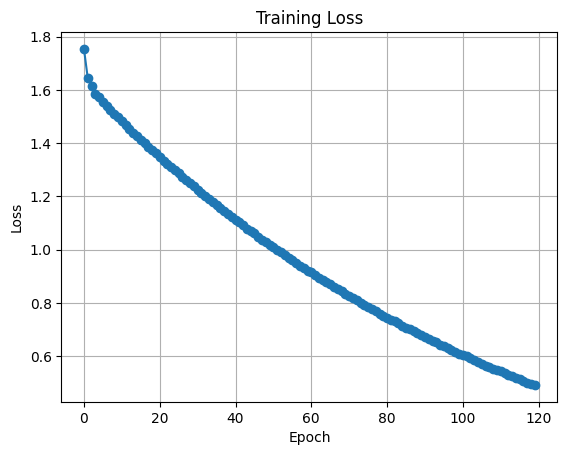

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
dataset = SimCLRDataset(images, reps, simclr_transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 120
history = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)
        o1 = model(t1)
        o2 = model(t2)
        loss = aggregate_loss(o1, o2, yv, alpha=0.9, beta=0.05)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    history.append(avg_loss)
    print(f"[Epoch {epoch}/{num_epochs}] Loss: {avg_loss:.4f}")

plt.plot(history, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### vgg model

In [ ]:
from torchvision.models import vgg16_bn

class StolenVGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=False).features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # spatial -> (N, 512, 1, 1)
        self.head = nn.Sequential(
            nn.Flatten(),  # -> (N, 512)
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x)
        return x


In [ ]:
def aggregate_loss(o1, o2, yv, alpha=0.9, beta=0.05):
    loss_A = F.mse_loss(o1, yv)                          # alignment with victim rep
    loss_B = F.mse_loss(o2, o1.detach())                 # consistency across views
    cosine_term = 1 - F.cosine_similarity(o1, yv, dim=1).mean()
    return alpha * loss_A + (1 - alpha) * loss_B + beta * cosine_term


[Epoch 1] Loss: 1.6560
[Epoch 2] Loss: 1.5641
[Epoch 3] Loss: 1.5157
[Epoch 4] Loss: 1.4617
[Epoch 5] Loss: 1.4252
[Epoch 6] Loss: 1.3769
[Epoch 7] Loss: 1.3339
[Epoch 8] Loss: 1.2928
[Epoch 9] Loss: 1.2544
[Epoch 10] Loss: 1.2134
[Epoch 11] Loss: 1.1761
[Epoch 12] Loss: 1.1380
[Epoch 13] Loss: 1.1034
[Epoch 14] Loss: 1.0694
[Epoch 15] Loss: 1.0337
[Epoch 16] Loss: 1.0000
[Epoch 17] Loss: 0.9685
[Epoch 18] Loss: 0.9382
[Epoch 19] Loss: 0.9066
[Epoch 20] Loss: 0.8770
[Epoch 21] Loss: 0.8473
[Epoch 22] Loss: 0.8195
[Epoch 23] Loss: 0.7938
[Epoch 24] Loss: 0.7675
[Epoch 25] Loss: 0.7434
[Epoch 26] Loss: 0.7177
[Epoch 27] Loss: 0.6941
[Epoch 28] Loss: 0.6689
[Epoch 29] Loss: 0.6498
[Epoch 30] Loss: 0.6253
[Epoch 31] Loss: 0.6060
[Epoch 32] Loss: 0.5858
[Epoch 33] Loss: 0.5644
[Epoch 34] Loss: 0.5441
[Epoch 35] Loss: 0.5251
[Epoch 36] Loss: 0.5069
[Epoch 37] Loss: 0.4900
[Epoch 38] Loss: 0.4718
[Epoch 39] Loss: 0.4553
[Epoch 40] Loss: 0.4404
[Epoch 41] Loss: 0.4241
[Epoch 42] Loss: 0.4101
[

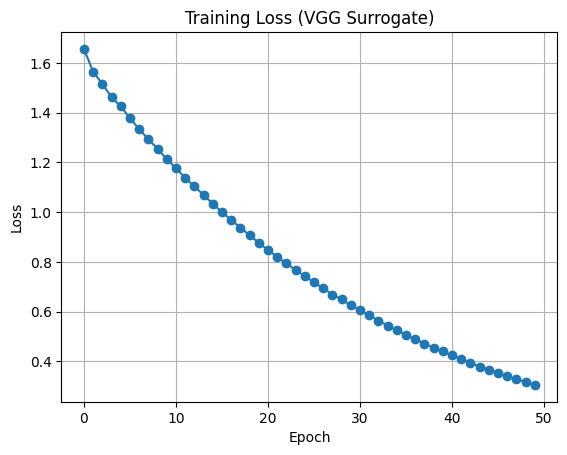

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenVGG().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 0 )
dataset = SimCLRDataset(images, reps, simclr_transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# loader = DataLoader(dataset, batch_size=64, shuffle=True)
epochs = 50
losses = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)
        o1 = model(t1)
        o2 = model(t2)
        loss = aggregate_loss(o1, o2, yv)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(loader)
    losses.append(avg)
    print(f"[Epoch {epoch}] Loss: {avg:.4f}")

plt.plot(losses, marker='o')
plt.title("Training Loss (VGG Surrogate)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### cosine norm loss

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1] Loss: 0.5474
[Epoch 2] Loss: 0.1474
[Epoch 3] Loss: 0.0379
[Epoch 4] Loss: 0.0126
[Epoch 5] Loss: 0.0065
[Epoch 6] Loss: 0.0045
[Epoch 7] Loss: 0.0038
[Epoch 8] Loss: 0.0032
[Epoch 9] Loss: 0.0028
[Epoch 10] Loss: 0.0026
[Epoch 11] Loss: 0.0023
[Epoch 12] Loss: 0.0021
[Epoch 13] Loss: 0.0020
[Epoch 14] Loss: 0.0019
[Epoch 15] Loss: 0.0018
[Epoch 16] Loss: 0.0017
[Epoch 17] Loss: 0.0017
[Epoch 18] Loss: 0.0017
[Epoch 19] Loss: 0.0016
[Epoch 20] Loss: 0.0015
[Epoch 21] Loss: 0.0015
[Epoch 22] Loss: 0.0015
[Epoch 23] Loss: 0.0014
[Epoch 24] Loss: 0.0014
[Epoch 25] Loss: 0.0014
[Epoch 26] Loss: 0.0014
[Epoch 27] Loss: 0.0014
[Epoch 28] Loss: 0.0014
[Epoch 29] Loss: 0.0015
[Epoch 30] Loss: 0.0014
[Epoch 31] Loss: 0.0014
[Epoch 32] Loss: 0.0013
[Epoch 33] Loss: 0.0014
[Epoch 34] Loss: 0.0014
[Epoch 35] Loss: 0.0013


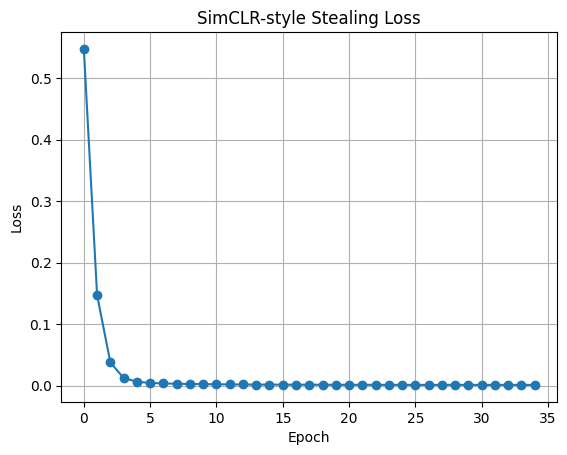

In [ ]:
def cosine_loss(x1, x2):
    x1 = F.normalize(x1, dim=1)
    x2 = F.normalize(x2, dim=1)
    return 1 - (x1 * x2).sum(dim=1).mean()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StolenEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(SimCLRDataset(images, reps, simclr_transform), batch_size=64, shuffle=True)

alpha = 0.9  # weight between victim alignment and self-consistency
num_epochs = 35
loss_history = []

for epoch in range(1, num_epochs+1):
    model.train()
    total = 0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        optimizer.zero_grad()
        o1 = model(t1)         # (B,1024)
        o2 = model(t2)         # (B,1024)
        loss_A = cosine_loss(o1, yv)
        loss_B = cosine_loss(o2, o1.detach())
        loss = alpha * loss_A + (1 - alpha) * loss_B        # cosine similarity loss
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    loss_history.append(avg)
    print(f"[Epoch {epoch}] Loss: {avg:.4f}")

# Plot training loss
plt.plot(loss_history, marker='o')
plt.title("SimCLR-style Stealing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
! pip install -q onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 90.6 MB/s eta 0:00:00


### Momentum‑Teacher Distillation (DINO‐Style)


In [ ]:
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Student model (ResNet18 + MLP head as before)
student = StolenEncoder().to(device)

# Teacher is an EMA copy of student; parameters frozen
teacher = copy.deepcopy(student)
for p in teacher.parameters():
    p.requires_grad_(False)

# Optimizer & scheduler
optimizer = torch.optim.AdamW(student.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

print("✅ Student & Teacher ready on", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Student & Teacher ready on cuda


[Epoch 1/100] Loss: 0.014408
[Epoch 2/100] Loss: 0.013624
[Epoch 3/100] Loss: 0.012345
[Epoch 4/100] Loss: 0.011638
[Epoch 5/100] Loss: 0.010941
[Epoch 6/100] Loss: 0.010018
[Epoch 7/100] Loss: 0.009567
[Epoch 8/100] Loss: 0.008862
[Epoch 9/100] Loss: 0.008388
[Epoch 10/100] Loss: 0.007936
[Epoch 11/100] Loss: 0.007488
[Epoch 12/100] Loss: 0.006927
[Epoch 13/100] Loss: 0.006286
[Epoch 14/100] Loss: 0.005966
[Epoch 15/100] Loss: 0.005771
[Epoch 16/100] Loss: 0.005418
[Epoch 17/100] Loss: 0.005116
[Epoch 18/100] Loss: 0.004891
[Epoch 19/100] Loss: 0.004674
[Epoch 20/100] Loss: 0.004537
[Epoch 21/100] Loss: 0.004404
[Epoch 22/100] Loss: 0.004170
[Epoch 23/100] Loss: 0.003988
[Epoch 24/100] Loss: 0.003898
[Epoch 25/100] Loss: 0.003807
[Epoch 26/100] Loss: 0.003621
[Epoch 27/100] Loss: 0.003627
[Epoch 28/100] Loss: 0.003538
[Epoch 29/100] Loss: 0.003408
[Epoch 30/100] Loss: 0.003320
[Epoch 31/100] Loss: 0.003203
[Epoch 32/100] Loss: 0.003247
[Epoch 33/100] Loss: 0.003111
[Epoch 34/100] Loss

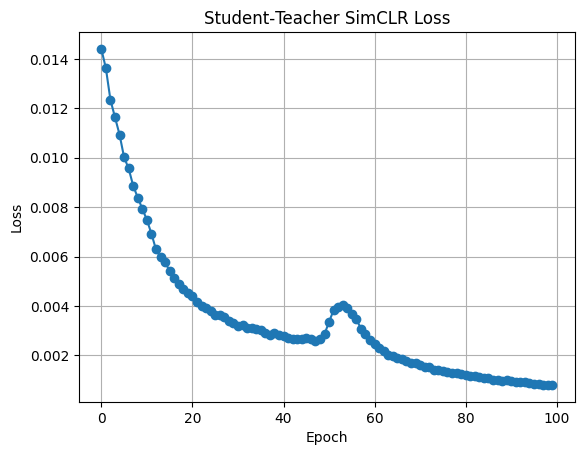

In [ ]:
from torch.nn import MSELoss

m = 0.995               # EMA momentum
alpha = 0.9             # keep your previous best weight
num_epochs = 100        # you can bump up to 200–300
batch_size = 32

loader = DataLoader(SimCLRDataset(images, reps, simclr_transform),
                    batch_size=batch_size, shuffle=True, num_workers=2)

loss_fn = MSELoss()
history = []

for epoch in range(1, num_epochs+1):
    student.train()
    total_loss = 0.0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        # Student forward
        o1 = student(t1)
        o2 = student(t2)

        # Teacher forward (no grad)
        with torch.no_grad():
            t_rep = teacher(t1)

        # Loss: student→teacher + student self‑consistency
        loss_A = loss_fn(o1, t_rep)
        loss_B = loss_fn(o2, o1.detach())
        loss = alpha * loss_A + (1 - alpha) * loss_B

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(epoch + total_loss)

        total_loss += loss.item()

        # EMA update for teacher
        with torch.no_grad():
            for st_p, te_p in zip(student.parameters(), teacher.parameters()):
                te_p.data.mul_(m).add_(st_p.data, alpha=1 - m)

    avg = total_loss / len(loader)
    history.append(avg)
    print(f"[Epoch {epoch}/{num_epochs}] Loss: {avg:.6f}")

# Plot convergence
plt.plot(history, marker="o")
plt.title("Student‑Teacher SimCLR Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
import torch.onnx

ONNX_OUT = "/content/models/model_Sim_CLR_DINO.onnx"
student.eval()

dummy = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(
    student,
    dummy,
    ONNX_OUT,
    input_names=["x"],
    output_names=["embedding"],
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
)

print(f"✅ Exported student ONNX model to: {ONNX_OUT}")


✅ Exported student ONNX model to: /content/models/model_Sim_CLR_DINO.onnx


### DINO_150 epochs

In [ ]:
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Student model (ResNet18 + MLP head as before)
student = StolenEncoder().to(device)

# Teacher is an EMA copy of student; parameters frozen
teacher = copy.deepcopy(student)
for p in teacher.parameters():
    p.requires_grad_(False)

# Optimizer & scheduler
optimizer = torch.optim.AdamW(student.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)

print("✅ Student & Teacher ready on", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Student & Teacher ready on cuda


[Epoch 1/100] Loss: 0.014992
[Epoch 2/100] Loss: 0.013775
[Epoch 3/100] Loss: 0.012906
[Epoch 4/100] Loss: 0.011557
[Epoch 5/100] Loss: 0.010830
[Epoch 6/100] Loss: 0.010070
[Epoch 7/100] Loss: 0.009338
[Epoch 8/100] Loss: 0.009050
[Epoch 9/100] Loss: 0.008041
[Epoch 10/100] Loss: 0.007642
[Epoch 11/100] Loss: 0.007156
[Epoch 12/100] Loss: 0.006856
[Epoch 13/100] Loss: 0.006549
[Epoch 14/100] Loss: 0.006263
[Epoch 15/100] Loss: 0.005957
[Epoch 16/100] Loss: 0.005786
[Epoch 17/100] Loss: 0.005505
[Epoch 18/100] Loss: 0.005128
[Epoch 19/100] Loss: 0.004868
[Epoch 20/100] Loss: 0.004646
[Epoch 21/100] Loss: 0.004440
[Epoch 22/100] Loss: 0.004245
[Epoch 23/100] Loss: 0.004076
[Epoch 24/100] Loss: 0.003889
[Epoch 25/100] Loss: 0.003805
[Epoch 26/100] Loss: 0.003696
[Epoch 27/100] Loss: 0.003678
[Epoch 28/100] Loss: 0.003592
[Epoch 29/100] Loss: 0.003422
[Epoch 30/100] Loss: 0.003343
[Epoch 31/100] Loss: 0.003308
[Epoch 32/100] Loss: 0.003229
[Epoch 33/100] Loss: 0.003213
[Epoch 34/100] Loss

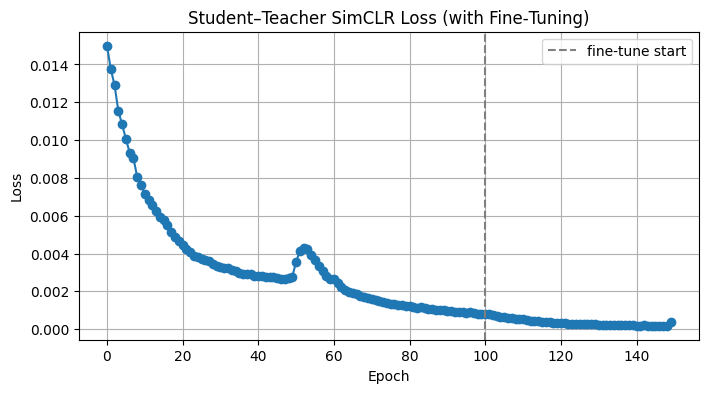

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# === Hyperparameters ===
initial_lr   = 1e-4
finetune_lr  = 1e-5
weight_decay = 1e-6
batch_size   = 32
num_epochs1  = 100   # initial phase
num_epochs2  = 50    # fine‑tuning phase
alpha        = 0.9
ema_momentum = 0.995

loader = DataLoader(
    SimCLRDataset(images, reps, simclr_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# === Training Loop Phase 1 (0 → 100) ===
loss_history = []
for epoch in range(1, num_epochs1 + 1):
    student.train()
    total_loss = 0.0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        # Forward
        o1 = student(t1)
        o2 = student(t2)
        with torch.no_grad():
            t_rep = teacher(t1)

        # Loss
        loss_A = F.mse_loss(o1, t_rep)
        loss_B = F.mse_loss(o2, o1.detach())
        loss   = alpha * loss_A + (1 - alpha) * loss_B

        # Backprop + EMA
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(epoch + total_loss)

        with torch.no_grad():
            for sp, tp in zip(student.parameters(), teacher.parameters()):
                tp.data.mul_(ema_momentum).add_(sp.data, alpha=1 - ema_momentum)

        total_loss += loss.item()

    avg = total_loss / len(loader)
    loss_history.append(avg)
    print(f"[Epoch {epoch}/{num_epochs1}] Loss: {avg:.6f}")

# === Adjust LR & EMA for Fine‑Tuning ===
print("\n🎯 Starting fine‑tuning phase:")
for pg in optimizer.param_groups:
    pg['lr'] = finetune_lr
ema_momentum = 0.99

# (Optional) reduce batch size
loader = DataLoader(
    SimCLRDataset(images, reps, simclr_transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

# === Training Loop Phase 2 (101 → 150) ===
for epoch in range(num_epochs1 + 1, num_epochs1 + num_epochs2 + 1):
    student.train()
    total_loss = 0.0

    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        o1 = student(t1)
        o2 = student(t2)
        with torch.no_grad():
            t_rep = teacher(t1)

        loss_A = F.mse_loss(o1, t_rep)
        loss_B = F.mse_loss(o2, o1.detach())
        loss   = alpha * loss_A + (1 - alpha) * loss_B

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(epoch + total_loss)

        with torch.no_grad():
            for sp, tp in zip(student.parameters(), teacher.parameters()):
                tp.data.mul_(ema_momentum).add_(sp.data, alpha=1 - ema_momentum)

        total_loss += loss.item()

    avg = total_loss / len(loader)
    loss_history.append(avg)
    print(f"[Epoch {epoch}/{num_epochs1 + num_epochs2}] Loss: {avg:.6f}")

# === Plot the full training curve ===
plt.figure(figsize=(8,4))
plt.plot(loss_history, marker='o')
plt.axvline(num_epochs1, color='gray', linestyle='--', label='fine-tune start')
plt.title("Student–Teacher SimCLR Loss (with Fine‑Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch.onnx

ONNX_OUT = "/content/models/model_Sim_CLR_DINO_150_optim.onnx"
student.eval()

dummy = torch.randn(1, 3, 32, 32).to(device)
torch.onnx.export(
    student,
    dummy,
    ONNX_OUT,
    input_names=["x"],
    output_names=["embedding"],
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
)

print(f"✅ Exported student ONNX model to: {ONNX_OUT}")


✅ Exported student ONNX model to: /content/models/model_Sim_CLR_DINO_150_optim.onnx


### Orthogonal Procrustes

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision import models

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.models as models



class StolenEncoder(nn.Module):
    """
    ResNet-18 backbone  ➜ 2-layer MLP ➜ (optional) orthogonal fixer.
    """
    def __init__(self, add_fixer=True):
        super().__init__()

        # ── backbone ────────────────────────────────────────────────────────────
        resnet = models.resnet18(weights=None)          # if you want pretrained: weights="IMAGENET1K_V1"
        resnet.fc = nn.Identity()                       # <-- kill 1000-way classifier
        self.backbone = resnet                          # output (B,512)

        # ── projection head ────────────────────────────────────────────────────
        self.proj_head = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024)
        )

        # ── optional Procrustes fixer ──────────────────────────────────────────
        self.use_fixer = add_fixer
        if self.use_fixer:
            self.fixer = nn.Linear(1024, 1024, bias=False)
            nn.init.eye_(self.fixer.weight)             # start as identity

    def encode(self, x):
        h = self.backbone(x)            # (B,512)
        z = self.proj_head(h)           # (B,1024)
        return z

    def forward(self, x):
        z = self.encode(x)
        if self.use_fixer:
            z = self.fixer(z)
        return z


In [ ]:
@torch.no_grad()
def compute_and_set_procrustes(model, dataloader, victim_embeds):
    """
    Builds A (student) and B (victim) matrices with matching order
    and solves for the optimal orthogonal rotation R.
    """
    model.eval()
    device = next(model.parameters()).device

    A_list = []
    for imgs, _, _ in dataloader:        # only need one view
        imgs = imgs.to(device)
        A_list.append(model.encode(imgs).cpu())   # <-- use encode(), NOT backbone()
    A = torch.cat(A_list, dim=0)         # (N,1024)
    B = victim_embeds                    # (N,1024) – torch tensor, same ordering

    # Orthogonal Procrustes: R = argmin ‖RA – B‖_F
    M = B.T @ A                          # (1024,1024)
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    R = U @ Vt                           # orthogonal

    model.fixer.weight.data.copy_(R.to(device))


[Epoch 1/200] steal-loss 0.3119
[Epoch 2/200] steal-loss 0.0478
[Epoch 3/200] steal-loss 0.0220
[Epoch 4/200] steal-loss 0.0138
[Epoch 5/200] steal-loss 0.0105
[Epoch 6/200] steal-loss 0.0085
[Epoch 7/200] steal-loss 0.0064
[Epoch 8/200] steal-loss 0.0058
[Epoch 9/200] steal-loss 0.0058
[Epoch 10/200] steal-loss 0.0045
[Epoch 11/200] steal-loss 0.0047
[Epoch 12/200] steal-loss 0.0044
[Epoch 13/200] steal-loss 0.0041
[Epoch 14/200] steal-loss 0.0034
[Epoch 15/200] steal-loss 0.0035
[Epoch 16/200] steal-loss 0.0035
[Epoch 17/200] steal-loss 0.0039
[Epoch 18/200] steal-loss 0.0034
[Epoch 19/200] steal-loss 0.0032
[Epoch 20/200] steal-loss 0.0030
[Epoch 21/200] steal-loss 0.0029
[Epoch 22/200] steal-loss 0.0030
[Epoch 23/200] steal-loss 0.0030
[Epoch 24/200] steal-loss 0.0028
[Epoch 25/200] steal-loss 0.0028
[Epoch 26/200] steal-loss 0.0027
[Epoch 27/200] steal-loss 0.0025
[Epoch 28/200] steal-loss 0.0028
[Epoch 29/200] steal-loss 0.0028
[Epoch 30/200] steal-loss 0.0026
[Epoch 31/200] stea

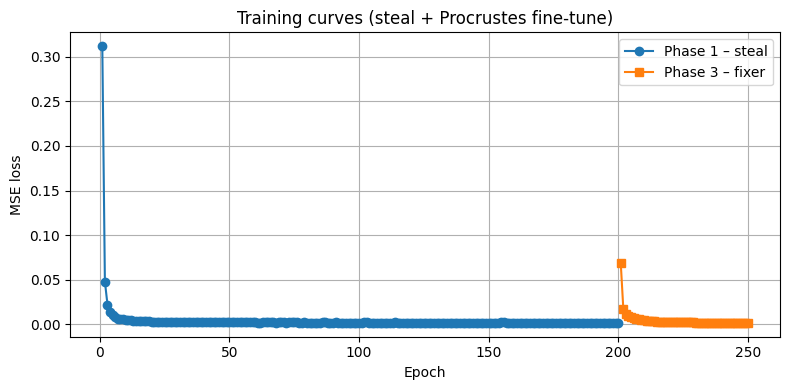

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
# … assume StolenEncoder, compute_and_set_procrustes, DataLoader etc. are already imported …

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(
    SimCLRDataset(images, reps, simclr_transform),
    batch_size=64, shuffle=True
)

# ───────────────────────────────────── Phase 1 – main steal ────────────────────────────────────
model = StolenEncoder(add_fixer=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
alpha = 0.98
num_epochs = 200
train_loss = []

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        opt.zero_grad()
        o1 = model(t1)
        o2 = model(t2)
        # loss = alpha * F.mse_loss(o1, yv) + (1 - alpha) * F.mse_loss(o2, o1.detach())
        loss = 1 - F.cosine_similarity(student_output, victim_output).mean()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    train_loss.append(epoch_loss)
    print(f"[Epoch {epoch}/{num_epochs}] steal-loss {epoch_loss:.4f}")

# ───────────────────────────────────── Phase 2 – Procrustes ───────────────────────────────────
victim_tensor = torch.tensor(reps, dtype=torch.float32)
compute_and_set_procrustes(model, loader, victim_tensor)

# ───────────────────────────────────── Phase 3 – fine-tune fixer ──────────────────────────────
for p in model.parameters():          # freeze everything …
    p.requires_grad_(False)
for p in model.fixer.parameters():    # … except the fixer
    p.requires_grad_(True)

opt = torch.optim.Adam(model.fixer.parameters(), lr=1e-4)
fine_epochs = 50
fixer_loss = []

for epoch in range(1, fine_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for imgs, _, yv in loader:         # one view is enough here
        imgs, yv = imgs.to(device), yv.to(device)

        opt.zero_grad()
        preds = model(imgs)
        loss = F.mse_loss(preds, yv)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    fixer_loss.append(epoch_loss)
    print(f"[Fine-tune {epoch}/{fine_epochs}] fixer-loss {epoch_loss:.4f}")

# ───────────────────────────────────── Plots ──────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs + 1), train_loss, marker='o', label='Phase 1 – steal')
plt.plot(range(num_epochs + 1, num_epochs + fine_epochs + 1),
         fixer_loss, marker='s', label='Phase 3 – fixer')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training curves (steal + Procrustes fine-tune)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Prcrustes optim loop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# Encoder Model (ResNet18 base)
# ------------------------------
class StolenEncoder(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])  # Remove FC
        self.head = nn.Linear(512, 1024)

    def forward(self, x):
        x = self.encoder(x).squeeze(-1).squeeze(-1)  # B x 512
        x = self.head(x)                             # B x 1024
        return x


# ------------------------------
# Post-hoc Orthogonal Fixer
# ------------------------------
class ProcrustesFixer(nn.Module):
    def __init__(self, dim=1024):
        super().__init__()
        self.fixer = nn.Linear(dim, dim, bias=False)

    def forward(self, x):
        return self.fixer(x)

# ------------------------------
# Training Configs
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 0.98
steal_epochs = 200
fixer_epochs = 50

# Assuming you already have:
# - `SimCLRDataset(images, reps, simclr_transform)`
# - `resnet18 = torchvision.models.resnet18(pretrained=False)`
# - `loader = DataLoader(...)`
from torchvision.models import resnet18
model = StolenEncoder(resnet18()).to(device)
fixer = ProcrustesFixer().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
fixer_opt = torch.optim.Adam(fixer.parameters(), lr=1e-4)

loss_history = []
fixer_loss_history = []

# ------------------------------
# Phase 1: Stealing (cosine norm)
# ------------------------------
model.train()
for epoch in range(1, steal_epochs+1):
    total = 0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        optimizer.zero_grad()
        o1 = model(t1)
        o2 = model(t2)

        # Normalize all vectors for cosine similarity
        o1_norm = F.normalize(o1, dim=1)
        o2_norm = F.normalize(o2, dim=1)
        yv_norm = F.normalize(yv, dim=1)

        loss_A = 1 - F.cosine_similarity(o1_norm, yv_norm).mean()
        loss_B = 1 - F.cosine_similarity(o2_norm, o1_norm.detach()).mean()

        loss = alpha * loss_A + (1 - alpha) * loss_B
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    loss_history.append(avg)
    print(f"[Steal Epoch {epoch}] Loss: {avg:.6f}")

# ------------------------------
# Phase 2: Fine-tune fixer layer
# ------------------------------
model.eval()
fixer.train()
for epoch in range(1, fixer_epochs+1):
    total = 0
    for t1, _, yv in loader:
        t1, yv = t1.to(device), yv.to(device)
        with torch.no_grad():
            o = model(t1)

        o = F.normalize(o, dim=1)
        yv = F.normalize(yv, dim=1)

        fixer_opt.zero_grad()
        o_fixed = fixer(o)
        loss = 1 - F.cosine_similarity(o_fixed, yv).mean()
        loss.backward()
        fixer_opt.step()
        total += loss.item()

    avg = total / len(loader)
    fixer_loss_history.append(avg)
    print(f"[Fixer Epoch {epoch}] Loss: {avg:.6f}")

# ------------------------------
# Plot Both Training Curves
# ------------------------------
plt.figure(figsize=(10,5))
plt.plot(loss_history, label="Phase 1 – steal", marker='o')
plt.plot(range(steal_epochs, steal_epochs + fixer_epochs), fixer_loss_history, label="Phase 2 – fixer", marker='s')
plt.title("Training curves (steal + Procrustes fine-tune)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Embed whitening

In [ ]:
import torch, torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import numpy as np

In [ ]:
# 1) Precompute whitening (on CPU)
yv_all = torch.from_numpy(reps).float()         # (N,1024)
mu    = yv_all.mean(0, keepdim=True)            # (1,1024)
X     = yv_all - mu
cov   = (X.T @ X) / (X.size(0)-1)
eps   = 1e-5
U, S, _ = torch.linalg.svd(cov + eps*torch.eye(1024))
W     = U @ torch.diag(1.0/torch.sqrt(S)) @ U.T # (1024,1024)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mu, W = mu.to(device), W.to(device)

In [ ]:
def global_whiten(x):
    return (x - mu) @ W


In [ ]:
# 2) Model + Procrustes helper
class StolenEncoder(nn.Module):
    def __init__(self, add_fixer=True):
        super().__init__()
        base = resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.backbone = base
        self.head     = nn.Linear(512, 1024)
        self.add_fixer = add_fixer
        if add_fixer:
            self.fixer = nn.Linear(1024, 1024, bias=False)
            nn.init.eye_(self.fixer.weight)

    def encode(self, x):
        h = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.head(h)

    def forward(self, x):
        z = self.encode(x)
        return self.fixer(z) if self.add_fixer else z

In [ ]:
@torch.no_grad()
def compute_and_set_procrustes(model, loader, victim_tensor):
    model.eval()
    A = []
    for t1, _, _ in loader:
        A.append(model.encode(t1.to(device)).cpu())
    A = torch.cat(A, 0)
    B = victim_tensor          # CPU tensor (N,1024)
    M = B.T @ A
    U, _, Vt = torch.linalg.svd(M)
    R = U @ Vt
    model.fixer.weight.data.copy_(R.to(device))

In [ ]:
# 3) DataLoader
dataset = SimCLRDataset(images, reps, simclr_transform)
loader  = DataLoader(dataset, batch_size=64, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1/200] Loss: 68338.6345
[Epoch 2/200] Loss: 28126.4131
[Epoch 3/200] Loss: 12449.0470
[Epoch 4/200] Loss: 5560.6551
[Epoch 5/200] Loss: 2756.6933
[Epoch 6/200] Loss: 1596.9044
[Epoch 7/200] Loss: 1266.0509
[Epoch 8/200] Loss: 1051.2197
[Epoch 9/200] Loss: 866.5318
[Epoch 10/200] Loss: 608.9248
[Epoch 11/200] Loss: 656.1986
[Epoch 12/200] Loss: 640.1217
[Epoch 13/200] Loss: 637.4390
[Epoch 14/200] Loss: 526.2255
[Epoch 15/200] Loss: 417.0859
[Epoch 16/200] Loss: 393.6580
[Epoch 17/200] Loss: 379.4173
[Epoch 18/200] Loss: 428.5146
[Epoch 19/200] Loss: 341.5703
[Epoch 20/200] Loss: 309.6901
[Epoch 21/200] Loss: 254.7357
[Epoch 22/200] Loss: 223.5006
[Epoch 23/200] Loss: 335.0918
[Epoch 24/200] Loss: 292.5183
[Epoch 25/200] Loss: 239.7727
[Epoch 26/200] Loss: 220.7591
[Epoch 27/200] Loss: 355.3674
[Epoch 28/200] Loss: 259.7673
[Epoch 29/200] Loss: 195.5532
[Epoch 30/200] Loss: 143.8022
[Epoch 31/200] Loss: 215.3022
[Epoch 32/200] Loss: 196.5101
[Epoch 33/200] Loss: 218.6434
[Epoch 3

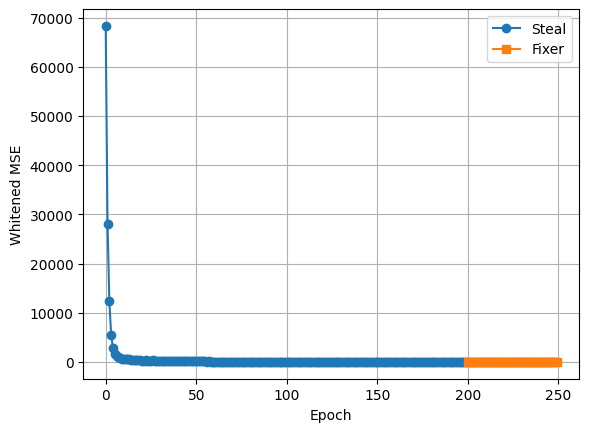

In [ ]:
# 4) Training Loop
model        = StolenEncoder(add_fixer=True).to(device)
opt          = torch.optim.Adam(model.parameters(), lr=1e-4)
alpha        = 0.98
steal_epochs = 200
loss_hist    = []

for epoch in range(1, steal_epochs+1):
    model.train()
    running = 0
    for t1, t2, yv in loader:
        t1, t2, yv = t1.to(device), t2.to(device), yv.to(device)

        opt.zero_grad()
        o1 = model.encode(t1)
        o2 = model.encode(t2)

        o1_w = global_whiten(o1)
        o2_w = global_whiten(o2)
        yv_w = global_whiten(yv)

        loss = alpha*F.mse_loss(o1_w, yv_w) + (1-alpha)*F.mse_loss(o2_w, o1_w.detach())
        loss.backward()
        opt.step()
        running += loss.item()

    avg = running/len(loader)
    loss_hist.append(avg)
    print(f"[Epoch {epoch}/{steal_epochs}] Loss: {avg:.4f}")

# 5) Procrustes + fixer fine-tune
victim_tensor = torch.from_numpy(reps).float()
compute_and_set_procrustes(model, loader, victim_tensor)

for p in model.parameters(): p.requires_grad_(False)
for p in model.fixer.parameters(): p.requires_grad_(True)

fixer_opt   = torch.optim.Adam(model.fixer.parameters(), lr=1e-4)
fine_epochs = 50
fixer_hist  = []

for epoch in range(1, fine_epochs+1):
    model.train()
    running = 0
    for t1, _, yv in loader:
        t1, yv = t1.to(device), yv.to(device)

        fixer_opt.zero_grad()
        preds = model.fixer(model.encode(t1))

        p_w = global_whiten(preds)
        y_w = global_whiten(yv)
        loss = F.mse_loss(p_w, y_w)

        loss.backward()
        fixer_opt.step()
        running += loss.item()

    avg = running/len(loader)
    fixer_hist.append(avg)
    print(f"[Fixer {epoch}/{fine_epochs}] Loss: {avg:.4f}")

# 6) Plot
plt.plot(loss_hist, marker='o', label='Steal')
plt.plot(range(steal_epochs, steal_epochs+fine_epochs), fixer_hist, marker='s', label='Fixer')
plt.xlabel("Epoch"); plt.ylabel("Whitened MSE")
plt.legend(); plt.grid(True); plt.show()

### SNN loss

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import numpy as np, matplotlib.pyplot as plt
import torch

In [ ]:

# ==============================================================
# 1.  Dataset: one victim rep, K cached augmentations
# ==============================================================

K = 32          # number of offline views to reuse
IMG_SIZE = 32   # original images are 32×32

class MultiViewDataset(Dataset):
    def __init__(self, images, victim_reps, transform, K=32):
        self.images  = images
        self.vreps   = torch.from_numpy(victim_reps).float()
        self.transform = transform
        self.K = K

    def __len__(self):
        return len(self.images) * self.K     # every aug counts as sample

    def __getitem__(self, idx):
        base_idx  = idx // self.K            # raw image index
        img       = self.images[base_idx]
        if img.mode != 'RGB':
            img = img.convert('RGB')
        aug      = self.transform(img)       # new augmentation
        v_rep    = self.vreps[base_idx]      # SAME victim rep for all K views
        return aug, v_rep


In [ ]:
# ==============================================================
# 2.  Whitening matrix (compute ONCE from victim reps)
# ==============================================================

yv_cpu = torch.from_numpy(reps).float()
mu  = yv_cpu.mean(0, keepdim=True)                        # (1,1024)
X   = yv_cpu - mu
cov = (X.T @ X) / (X.size(0)-1)                           # (1024,1024)
eps = 1e-5
U, S, _ = torch.linalg.svd(cov + eps*torch.eye(1024))
W = U @ torch.diag(1./torch.sqrt(S)) @ U.T                # whitening mat

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu, W  = mu.to(device), W.to(device)

def whiten(x):
    return (x - mu) @ W

In [ ]:
# ==============================================================
# 3.  Model (ResNet-18 backbone + MLP + optional fixer)
# ==============================================================

class StolenEncoder(nn.Module):
    def __init__(self, add_fixer=True):
        super().__init__()
        base = resnet18(pretrained=False)
        base.fc = nn.Identity()
        self.backbone = base                # output (B,512)
        self.head     = nn.Linear(512, 1024)
        self.add_fixer = add_fixer
        if add_fixer:
            self.fixer = nn.Linear(1024,1024, bias=False)
            nn.init.eye_(self.fixer.weight)

    def encode(self, x):
        h = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.head(h)

    def forward(self, x):
        z = self.encode(x)
        return self.fixer(z) if self.add_fixer else z

In [ ]:
# ==============================================================
# 4.  Soft-Nearest-Neighbour (SNN) Loss
# ==============================================================

def snn_loss(z, v_rep, tau=0.1):
    """
    z:      (B,1024) student outputs
    v_rep:  (B,1024) corresponding victim embeddings (same in each row group)
    """
    z   = F.normalize(z, dim=1)
    v   = F.normalize(v_rep, dim=1)
    sim = z @ v.T / tau                 # similarities to all victims in batch
    labels = torch.arange(z.size(0), device=z.device)
    return F.cross_entropy(sim, labels)

In [ ]:
# !pip install --upgrade "torch>=2.0" "torchvision>=0.15"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 863.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [ ]:
# ==============================================================
# 5.  Training  (Phase-1: steal with SNN; Phase-2: Procrustes; Phase-3: fixer fine-tune)
# ==============================================================

dataset = MultiViewDataset(images, reps, simclr_transform, K)
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

model = StolenEncoder(add_fixer=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 100
loss_hist = []

for ep in range(1, epochs+1):
    model.train()
    running = 0
    for aug, v in loader:
        aug, v = aug.to(device), v.to(device)
        opt.zero_grad()
        out = model.encode(aug)         # bypass fixer during steal stage
        loss = snn_loss(whiten(out), whiten(v))
        loss.backward()
        opt.step()
        running += loss.item()
    avg = running/len(loader)
    loss_hist.append(avg)
    print(f"[{ep:03d}/{epochs}] SNN-loss {avg:.4f}")

# ---------------- Phase-2  Procrustes ----------------
@torch.no_grad()
def set_procrustes(mdl):
    mdl.eval()
    stud = []
    v_tensor = torch.from_numpy(reps).float()
    base_loader = DataLoader(images, batch_size=256, shuffle=False)
    for img in base_loader:
        if img.mode != 'RGB': img = img.convert('RGB')
        img_t = simclr_transform(img).unsqueeze(0).to(device)
        stud.append(mdl.encode(img_t).cpu())
    A = torch.cat(stud,0)
    B = v_tensor
    M = B.T @ A
    U,S,Vt = torch.linalg.svd(M)
    R = U @ Vt
    mdl.fixer.weight.data.copy_(R.to(device))

set_procrustes(model)

# ---------------- Phase-3  Fixer fine-tune ----------------
for p in model.parameters(): p.requires_grad_(False)
for p in model.fixer.parameters(): p.requires_grad_(True)

fix_opt   = torch.optim.Adam(model.fixer.parameters(), lr=1e-4)
fine_ep   = 20
fix_hist  = []

for ep in range(1, fine_ep+1):
    running=0
    for aug, v in loader:
        aug, v = aug.to(device), v.to(device)
        fix_opt.zero_grad()
        out = model(aug)
        loss = F.mse_loss(whiten(out), whiten(v))
        loss.backward()
        fix_opt.step()
        running += loss.item()
    avg = running/len(loader)
    fix_hist.append(avg)
    print(f"[Fix {ep}/{fine_ep}] loss {avg:.4f}")

# ==============================================================
# 6.  Plot curves
# ==============================================================

plt.plot(loss_hist, marker='o', label='Phase-1  SNN')
plt.plot(range(epochs, epochs+fine_ep), fix_hist, marker='s', label='Phase-3  fixer')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[001/100] SNN-loss 4.6811
[002/100] SNN-loss 4.2939
[003/100] SNN-loss 3.9664
[004/100] SNN-loss 3.6884
[005/100] SNN-loss 3.4492
[006/100] SNN-loss 3.2594
[007/100] SNN-loss 3.0549
[008/100] SNN-loss 2.8913
[009/100] SNN-loss 2.7218
[010/100] SNN-loss 2.5745
[011/100] SNN-loss 2.4445
[012/100] SNN-loss 2.3126
[013/100] SNN-loss 2.2083
[014/100] SNN-loss 2.0916
[015/100] SNN-loss 1.9995
[016/100] SNN-loss 1.8931
[017/100] SNN-loss 1.8134
[018/100] SNN-loss 1.7339
[019/100] SNN-loss 1.6603
[020/100] SNN-loss 1.5880
[021/100] SNN-loss 1.5297
[022/100] SNN-loss 1.4715
[023/100] SNN-loss 1.4166
[024/100] SNN-loss 1.3706
[025/100] SNN-loss 1.3189
[026/100] SNN-loss 1.2775
[027/100] SNN-loss 1.2275
[028/100] SNN-loss 1.2001
[029/100] SNN-loss 1.1696
[030/100] SNN-loss 1.1272
[031/100] SNN-loss 1.1135
[032/100] SNN-loss 1.0740
[033/100] SNN-loss 1.0501
[034/100] SNN-loss 1.0146
[035/100] SNN-loss 0.9958
[036/100] SNN-loss 0.9735
[037/100] SNN-loss 0.9563
[038/100] SNN-loss 0.9336
[039/100] SN

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Fix 1/20] loss 917.5149
[Fix 2/20] loss 702.7459
[Fix 3/20] loss 595.6748
[Fix 4/20] loss 517.2220
[Fix 5/20] loss 457.9150
[Fix 6/20] loss 408.7561
[Fix 7/20] loss 368.2798
[Fix 8/20] loss 332.3831
[Fix 9/20] loss 302.5373
[Fix 10/20] loss 275.4169
[Fix 11/20] loss 251.3561
[Fix 12/20] loss 230.5266
[Fix 13/20] loss 210.8480
[Fix 14/20] loss 193.3073
[Fix 15/20] loss 177.6318
[Fix 16/20] loss 163.2211
[Fix 17/20] loss 150.9873
[Fix 18/20] loss 138.6289
[Fix 19/20] loss 127.9576
[Fix 20/20] loss 117.9988


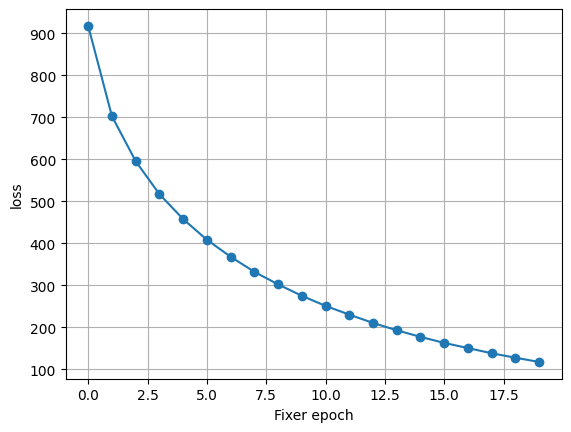

In [ ]:
# ------------------------------------------------------------
# 1.  A tiny dataset wrapper that turns each PIL image into a tensor
# ------------------------------------------------------------
from torch.utils.data import Dataset, DataLoader

class ImgTensorDataset(Dataset):
    def __init__(self, imgs, tfm):
        self.imgs, self.tfm = imgs, tfm
    def __len__(self):              return len(self.imgs)
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if img.mode != "RGB":
            img = img.convert("RGB")
        return self.tfm(img)        # returns CHW tensor

tensor_loader = DataLoader(
    ImgTensorDataset(images, simclr_transform),
    batch_size=256, shuffle=False,
    num_workers=4, pin_memory=True   # optional speed-ups
)

# ------------------------------------------------------------
# 2.  Re-compute the Procrustes rotation with the new loader
# ------------------------------------------------------------
@torch.no_grad()
def compute_and_set_procrustes(model, dl, victim_tensor):
    model.eval()
    student_vecs = []
    for batch in dl:                       # <-- now tensors, collate works
        batch = batch.to(device)
        student_vecs.append(model.encode(batch).cpu())
    A = torch.cat(student_vecs, dim=0)     # (N,1024)
    B = victim_tensor                      # (N,1024)
    U, _, Vt = torch.linalg.svd(B.T @ A)
    model.fixer.weight.data.copy_((U @ Vt).to(device))

victim_tensor = torch.from_numpy(reps).float()
compute_and_set_procrustes(model, tensor_loader, victim_tensor)

# ------------------------------------------------------------
# 3.  Run (or re-run) the fixer fine-tune – only a few minutes
# ------------------------------------------------------------
for p in model.parameters():           p.requires_grad_(False)
for p in model.fixer.parameters():     p.requires_grad_(True)

fix_opt   = torch.optim.Adam(model.fixer.parameters(), lr=1e-4)
fine_ep   = 20
fix_hist  = []

for ep in range(1, fine_ep+1):
    running = 0
    for aug, v_rep in loader:          # <-- your big augmentation loader
        aug, v_rep = aug.to(device), v_rep.to(device)

        fix_opt.zero_grad()
        preds = model(aug)             # goes through fixer
        loss  = F.mse_loss(whiten(preds), whiten(v_rep))
        loss.backward()
        fix_opt.step()
        running += loss.item()

    fix_hist.append(running/len(loader))
    print(f"[Fix {ep}/{fine_ep}] loss {fix_hist[-1]:.4f}")

# (optional) plot the fixer curve
plt.plot(range(len(fix_hist)), fix_hist, marker='o')
plt.xlabel('Fixer epoch'); plt.ylabel('loss'); plt.grid(True); plt.show()


### save model onnx

In [ ]:
! pip install -q onnx

In [ ]:
import os
import torch.onnx
import onnxruntime

# Path to save
# onnx_path = "/content/models/model_Sim_CLR_cosine_norm_loss.onnx"
# onnx_path = "/content/models/model_Sim_CLR_resnet50.onnx"
# onnx_path = "/content/models/model_Sim_CLR_MSE_loss_opt.onnx"
# onnx_path = "/content/models/model_Sim_CLR_DINO.onnx"
# onnx_path = "/content/models/model_Sim_CLR_Procrustes.onnx"
# onnx_path = "/content/models/model_Sim_CLR_Procrustes200.onnx"
# onnx_path = "/content/models/model_Sim_CLR_whitening_procrustes.onnx"
onnx_path = "/content/models/model_Sim_CLR_SNN.onnx"

# Dummy input for tracing (match (1,3,32,32))
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Export the model
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["x"],
    output_names=["embedding"],
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    verbose=False
)

print(f"Exported ONNX model to: {onnx_path}")


/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset11.py:903: UserWarning: This model contains a squeeze operation on dimension 1. The size of this dimension in the given input is 512. The model will be exported without the squeeze node. If the model is intended to be used with dynamic input shapes, please export with dynamic_axes argument.
  warnings.warn(


Exported ONNX model to: /content/models/model_Sim_CLR_SNN.onnx
